# Titanic: Machine Learning from Disaster

## Overview

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

This challenge is from [Kaggle.com](https://www.kaggle.com/c/titanic/overview)

First of all, we look at the data that they have provided us with. The data is already divided into 2 parts - `train.csv` and `test.csv`. First, we will do all the feature engineering and model fitting on the `train` set and then apply it to the `test` set.

Now, let's load the data

In [1]:
import os

TITANIC_PATH = os.path.join('datasets', 'titanic')

In [2]:
import pandas as pd

def load_titanic_data(filename, path=TITANIC_PATH):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_dataset = load_titanic_data("train.csv")
test_dataset = load_titanic_data("test.csv")

Let's look at the dataset.

In [4]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As we can see, almost **20%** of the data in **Age** is null. Around **77%** in **Cabin** is null, so we will mostly ignore it. And very few precent in **Embarked** contains null values. So, at the moment we can fill the null values in **Age** with the median age value.

Let's begin with the preprocessing pipeline.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("num_attr", DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
    ("imputer", SimpleImputer(strategy='median')),
])

In [8]:
num_pipeline.fit_transform(train_dataset)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Now, let's create a **Imputer** for categorical attributes.

In [9]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [10]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('cat_attr', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_one_hot', OneHotEncoder(sparse=False)),
])

In [11]:
cat_pipeline.fit_transform(train_dataset)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [12]:
#Full preprocessing pipeline
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [13]:
X_train = preprocess_pipeline.fit_transform(train_dataset)
X_train.shape

(891, 12)

In [14]:
y_train = train_dataset['Survived']

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)

0.6279683377308707

In [27]:
recall_score(y_train, y_train_pred)

0.695906432748538

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [33]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

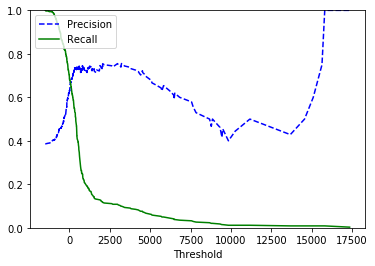

In [34]:
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

Clearly, this won't help in finding out the best model. Let's use the ROC curve.

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

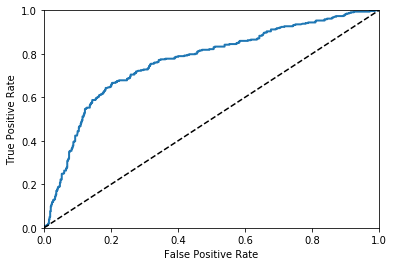

In [37]:
plot_roc_curve(fpr, tpr)
plt.show()

In [38]:
roc_auc_score(y_train, y_train_pred)

0.7195379158278209

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')

In [54]:
y_scores_forest = y_probas_forest[:, 1]

In [55]:
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train, y_scores_forest)

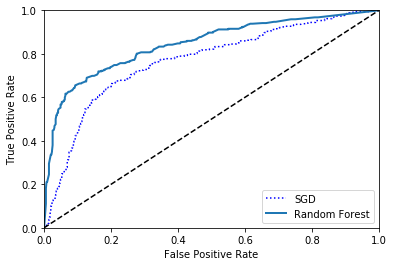

In [56]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [57]:
roc_auc_score(y_train, y_scores_forest)

0.8443075661223489

In [71]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=7)

In [72]:
forest_scores.mean()

0.8193783254771726

In [73]:
from sklearn.model_selection import RandomizedSearchCV

forest_clf = RandomForestClassifier(random_state=42)

param_distribs = {
    'n_estimators': [10, 50, 100, 200], 'max_features': ['auto'], 'min_samples_leaf': [5,10,20,50,100]
}

In [74]:
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring="neg_mean_squared_error", 
                                random_state=42, n_jobs=-1)

In [75]:
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [76]:
rnd_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [77]:
forest_clf_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [78]:
forest_clf_best_scores = cross_val_score(forest_clf_best, X_train, y_train, cv=10)

In [79]:
forest_clf_best_scores.mean()

0.8328674384292363

In [80]:
y_probas_forest = cross_val_predict(forest_clf_best, X_train, y_train, cv=3, method='predict_proba')

In [81]:
y_scores_forest_best = y_probas_forest[:, 1]

In [82]:
fpr_forest_best, tpr_forest_best, threshold_forest_best = roc_curve(y_train, y_scores_forest_best)

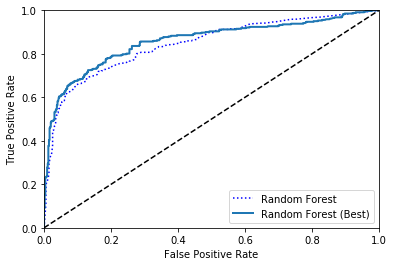

In [83]:
plt.plot(fpr_forest, tpr_forest, 'b:', label='Random Forest')
plot_roc_curve(fpr_forest_best, tpr_forest_best, label='Random Forest (Best)')
plt.legend(loc='lower right')
plt.show()

In [84]:
roc_auc_score(y_train, y_scores_forest_best)

0.8583309366311955

## Final Predictions

In [85]:
forest_clf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [88]:
X_test = preprocess_pipeline.transform(test_dataset)
forest_predictions = forest_clf_best.predict(X_test)

In [89]:
pd.DataFrame(forest_predictions, columns=['Survived'], index=list(range(892, 1310))).to_csv('predictions_v2.csv', index_label='PassengerId')